In [2]:
from google.colab import drive
# from google.colab import files
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score, f1_score



In [2]:
# Load your dataset
data = pd.read_csv('/content/drive/MyDrive/skin_lesion/undersampled_balanced_ham10000.csv')

# Assuming the last column is the label for binary classification
X = data.iloc[:, :-1].values  # Features
y = data.iloc[:, -1].values   # Labels

In [3]:
# Rescale and reshape the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape the data for CNN input (Ensure correct shape for DenseNet201)
X_reshaped = X_scaled.reshape(-1, 64, 64, 3)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

In [4]:
# Load DenseNet201 model pre-trained on ImageNet (exclude the top layers)
densenet_base = DenseNet201(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

In [5]:
# Freeze the layers of DenseNet201 base model
for layer in densenet_base.layers:
    layer.trainable = False

# Build the model using Sequential
model = Sequential([
    densenet_base,
    GlobalAveragePooling2D(),  # Global pooling to reduce spatial dimensions
    Dense(256, activation='relu'),  # Fully connected layer
    Dropout(0.5),  # Dropout to avoid overfitting
    Dense(1, activation='sigmoid')  # Binary classification output layer
])

In [6]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [7]:
# Define Data Generator for Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# Fit the data generator to the training data
datagen.fit(X_train)

In [8]:
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=0.001, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

class MetricsCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Get predictions on validation data
        y_pred = (self.model.predict(self.validation_data[0]) > 0.5).astype("int32")
        y_true = self.validation_data[1]

        # Print classification report metrics: precision, recall, f1-score
        report = classification_report(y_true, y_pred, output_dict=True)
        print(f"Epoch {epoch + 1} Classification Report:")
        print(f"Precision: {report['1']['precision']:.4f}, Recall: {report['1']['recall']:.4f}, F1-Score: {report['1']['f1-score']:.4f}")

# Create an instance of the MetricsCallback and set validation data for it
metrics_callback = MetricsCallback()
metrics_callback.validation_data = (X_test, y_test)

In [9]:
# Train the model
batch_size = 32
epochs = 30  # Adjust epochs for desired training
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test),
    epochs=epochs,
    callbacks=[lr_reduction, early_stopping, metrics_callback]
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 68s 936ms/step
Epoch 1 Classification Report:
Precision: 0.7071, Recall: 0.8977, F1-Score: 0.7911
251/251 ━━━━━━━━━━━━━━━━━━━━ 410s 1s/step - accuracy: 0.6881 - loss: 0.7941 - val_accuracy: 0.7664 - val_loss: 0.4666 - learning_rate: 0.0010
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 44s 698ms/step
Epoch 2 Classification Report:
Precision: 0.7208, Recall: 0.8865, F1-Score: 0.7951
251/251 ━━━━━━━━━━━━━━━━━━━━ 285s 1s/step - accuracy: 0.7568 - loss: 0.4778 - val_accuracy: 0.7748 - val_loss: 0.4498 - learning_rate: 0.0010
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 43s 686ms/step
Epoch 3 Classification Report:
Precision: 0.7650, Recall: 0.8247, F1-Score: 0.7938
251/251 ━━━━━━━━━━━━━━━━━━━━ 350s 1s/step - accuracy: 0.7737 - loss: 0.4506 - val_accuracy: 0.7888 - val_loss: 0.4308 - learning_rate: 0.0010
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 45s 721ms/step
Epoch 4 Classification Report:
Precision: 0.7332, Recall: 0.8744, F1-Score: 0.7976
251/251 ━━━━━━━━━━━━━━━━━━━━ 358s 1s/step

In [10]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


63/63 ━━━━━━━━━━━━━━━━━━━━ 44s 694ms/step - accuracy: 0.7951 - loss: 0.4088
Test Accuracy: 81.23%


In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet201 (Functional)             │ (None, 2, 2, 1920)          │      18,321,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1920)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         491,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,798,085 (75.52 MB)

 Trainable params: 492,033 (1.88 MB)

 Non-trainable params: 18,321,984 (69.89 MB)

 Optimizer params: 984,068 (3.75 MB)

In [12]:
model.save("FINAL_DENSE NET 201_model.h5")
model.save('FINAL_DENSE NET 201_model.keras')

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score

# Predictions
# y_train_pred = model.predict(X_train)
# y_train_pred_classes = np.argmax(y_train_pred, axis=1)
# y_train_true_classes = np.argmax(y_train, axis=1)

# y_test_pred = model.predict(X_test)
# y_test_pred_classes = np.argmax(y_test_pred, axis=1)
# y_test_true_classes = np.argmax(y_test, axis=1)

y_train_pred = model.predict(X_train)
y_train_pred_classes = (y_train_pred > 0.5).astype(int) # Convert probabilities to class labels (0 or 1)
#y_train_true_classes = np.argmax(y_train, axis=1) # This line is removed
y_train_true_classes = y_train # y_train already contains the true class labels

y_test_pred = model.predict(X_test)
y_test_pred_classes = (y_test_pred > 0.5).astype(int) # Convert probabilities to class labels (0 or 1)
#y_test_true_classes = np.argmax(y_test, axis=1) # This line is removed
y_test_true_classes = y_test # y_test already contains the true class labels

# Metrics
train_precision = precision_score(y_train_true_classes, y_train_pred_classes, average='weighted', zero_division=0)
train_recall = recall_score(y_train_true_classes, y_train_pred_classes, average='weighted', zero_division=0)
train_f1 = f1_score(y_train_true_classes, y_train_pred_classes, average='weighted')
train_accuracy = accuracy_score(y_train_true_classes, y_train_pred_classes)

test_precision = precision_score(y_test_true_classes, y_test_pred_classes, average='weighted', zero_division=0)
test_recall = recall_score(y_test_true_classes, y_test_pred_classes, average='weighted', zero_division=0)
test_f1 = f1_score(y_test_true_classes, y_test_pred_classes, average='weighted')
test_accuracy = accuracy_score(y_test_true_classes, y_test_pred_classes)

# Print Metrics
print("Training Metrics:")
print(f" Accuracy: {train_accuracy:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1-Score: {train_f1:.4f}")

print("\nTesting Metrics:")
print(f" Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1-Score: {test_f1:.4f}")

251/251 ━━━━━━━━━━━━━━━━━━━━ 188s 750ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 44s 698ms/step
Training Metrics:
 Accuracy: 0.8461, Precision: 0.8512, Recall: 0.8461, F1-Score: 0.8457

Testing Metrics:
 Accuracy: 0.8123, Precision: 0.8200, Recall: 0.8123, F1-Score: 0.8114


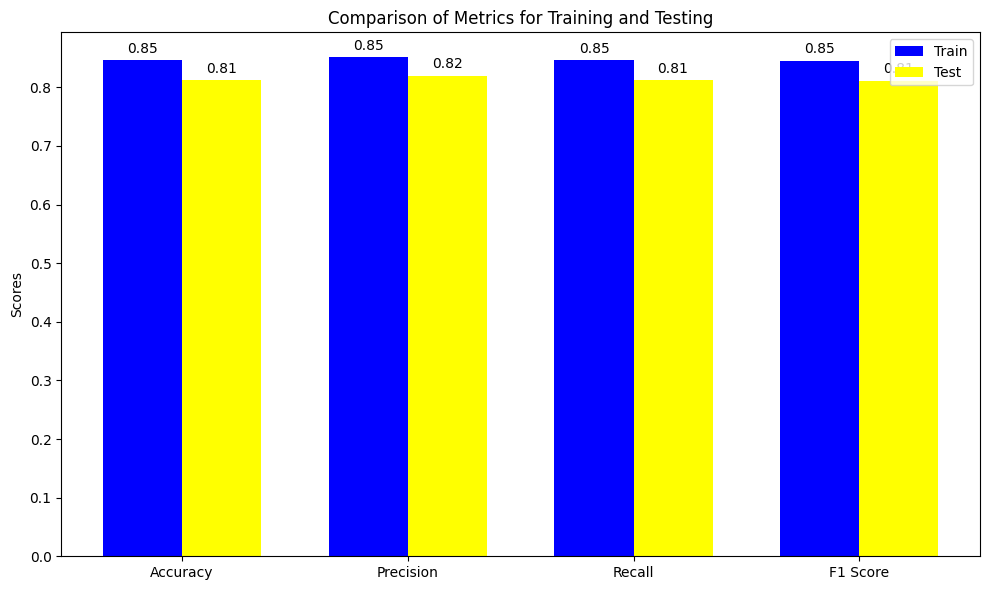

In [14]:
# Prepare data for plotting
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
train_values = [train_accuracy, train_precision, train_recall, train_f1]
test_values = [test_accuracy, test_precision, test_recall, test_f1]

# Set up the bar plot
width = 0.35  # Width of the bars
x = np.arange(len(metrics))  # The label locations

fig, ax = plt.subplots(figsize=(10, 6))

# Plot the bars for training and testing metrics
rects1 = ax.bar(x - width/2, train_values, width, label='Train', color='blue')
rects2 = ax.bar(x + width/2, test_values, width, label='Test', color='green')

# Add some text for labels, title and custom x-axis tick labels
ax.set_ylabel('Scores')
ax.set_title('Comparison of Metrics for Training and Testing')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Function to add the labels on top of the bars
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Add labels for each bar
add_labels(rects1)
add_labels(rects2)

# Show the plot
plt.tight_layout()
plt.show()

In [15]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)

# Predict probabilities and binary classes
y_pred_probs = model.predict(X_test).flatten()
y_pred = (y_pred_probs > 0.5).astype(int)

# Classification Report
print(classification_report(y_test, y_pred))


63/63 ━━━━━━━━━━━━━━━━━━━━ 42s 661ms/step - accuracy: 0.7951 - loss: 0.4088
63/63 ━━━━━━━━━━━━━━━━━━━━ 46s 733ms/step
              precision    recall  f1-score   support

           0       0.87      0.74      0.80      1016
           1       0.77      0.89      0.82       987

    accuracy                           0.81      2003
   macro avg       0.82      0.81      0.81      2003
weighted avg       0.82      0.81      0.81      2003



63/63 ━━━━━━━━━━━━━━━━━━━━ 44s 693ms/step


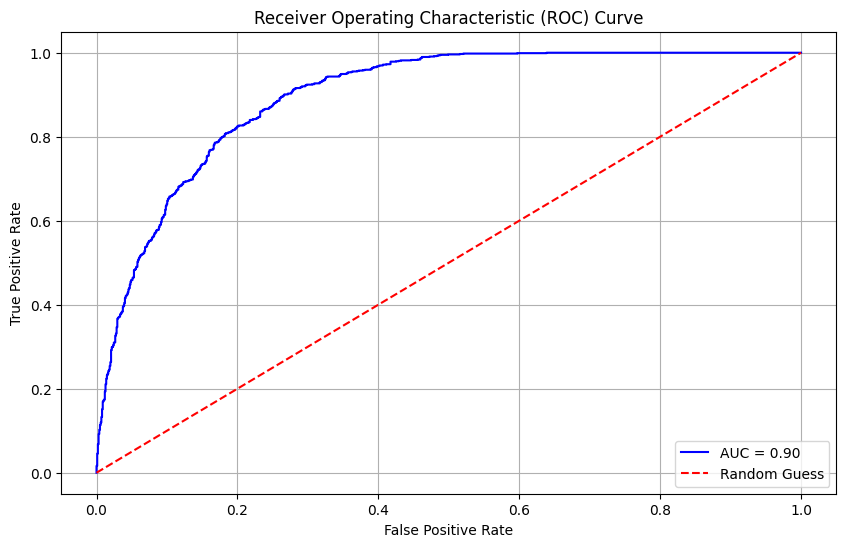

In [16]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Predict probabilities for the test set
y_pred_probs = model.predict(X_test).flatten()

# Compute false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot the AUC-ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guess')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()


In [17]:
# Classification report
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred, zero_division=0))

63/63 ━━━━━━━━━━━━━━━━━━━━ 47s 745ms/step
              precision    recall  f1-score   support

           0       0.87      0.74      0.80      1016
           1       0.77      0.89      0.82       987

    accuracy                           0.81      2003
   macro avg       0.82      0.81      0.81      2003
weighted avg       0.82      0.81      0.81      2003

